<a href="https://colab.research.google.com/github/farahmand-m/transgan/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import random

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import inception_v3

In [ ]:
%%capture 
!pip install pytorch-ignite 

In [ ]:
from ignite.handlers import DiskSaver
from ignite.engine.engine import Engine
from ignite.engine.events import Events
from ignite.handlers.checkpoint import Checkpoint
from ignite.handlers.ema_handler import EMAHandler
from ignite.metrics import FID, InceptionScore

In [ ]:
import PIL.Image as Image

## Reproducibility

In [ ]:
RANDOM_SEED = 7 

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [ ]:
torch.backends.cudnn.deterministic = True  # Limits cuDNN to deterministic algorithms.

## cuDNN

In [ ]:
torch.backends.cudnn.benchmark = False  # Due to changing input sizes, having it enabled can slow down training.

# Modeling

Our implementation is based on the official code published [on GitHub](https://github.com/VITA-Group/TransGAN). The authors have provided a script for training the model for several datasets, including [one](https://github.com/VITA-Group/TransGAN/blob/master/exps/cifar_train.py) for training on the CIFAR-10 dataset. This script trains the generator implemented in [`ViT_custom_rp.py`](https://github.com/VITA-Group/TransGAN/blob/master/models_search/ViT_custom_rp.py) against the discriminator implemented in [`ViT_custom_scale2_rp_noise.py`](https://github.com/VITA-Group/TransGAN/blob/master/models_search/ViT_custom_scale2_rp_noise.py). We will bring in the relavent pieces and build up the networks in a top-down manner.

The architectures of the adversarial models have been discussed in Section 3, where they provide the following figure, and Appendix B. There are, however, a few details still missing. We will be using the official implementation to fill in the gaps.

<img src="https://github.com/VITA-Group/TransGAN/raw/master/assets/TransGAN_1.png" alt="TransGAN" width="640"/>


## Generator

The authors state that "the generator takes the random noise as its input, and passes it through a multiple-layer perceptron (MLP) to a vector of length $H_0 × W_0 × C$. The vector is reshaped into a $H_0 × W_0$ resolution feature map (by default we use $H_0 = W_0 = 8$), each point a $C$-dimensional embedding." 

In the official implementation, this is achieved with the help of a simple `nn.Linear` layer. We can encapsulate this functionality as a module:

In [ ]:
class EmbeddingProjection(nn.Module):

    def __init__(self, in_features, out_features, base_size):
        super(EmbeddingProjection, self).__init__()
        self.in_features = in_features
        self.base_size = base_size
        self.out_features = out_features
        self.fc = nn.Linear(in_features, (self.base_size ** 2) * self.out_features)

    def forward(self, latents):
        flattened = self.fc(latents)
        return flattened.view(-1, self.base_size ** 2, self.out_features)


Next, this **feature map** is treated "as a length-64 sequence of $C$-dimensional tokens, combined with the **learnable positional encoding**." In the official implementation, they achieve this by defining a sequence with the same shape as stages' inputs as learnable parameters and add them to the sequences prior to each stage. They initialize these parameters by sampling from the **truncated normal distribution**. The authors provide a function based on [this method](https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf) for sampling from this distribution. However, this functuon has been since added to PyTorch itself and is accesible as `torch.nn.init.trunc_normal_`.

Inspired by DCGAN, the authors opt to then "gradually increase the feature map resolution until it meets the target resolution $H × W$." They refer to each step in this process as a **stage**, a building block which itself consists of several transformer encoder blocks.

In the official code, they implement the encoder blocks manually and refer to them as the [`Block` class](https://github.com/VITA-Group/TransGAN/blob/51b00d9ebdbcbeb42f4be2181fed394219f10e73/models_search/ViT_custom_rp.py#L143). This module isn't that dissimilar to the builtin one provided by PyTorch. However, it replaces the multi-head attention mechanism with the authors' proposed **grid attention**, and adds support for [DropPath](https://paperswithcode.com/method/droppath). According to the developers' comments, this was being considered as an alternative to Dropout, but it proved inferior and was eventually *dropped* (pun intended). Therefore, we can remove it to reduce complexity.

The grid attention mechanism limits the calculations to local regions to reduce the computational cost. The following figure compares this mechanism to the standard self-attention found in Transformers.

<img src="https://miro.medium.com/max/1400/1*FCKimTaswS4AZM9ecQTxKA.png" alt="TransGAN" width="640"/>

Another feature of the implemented attention mechanism is the use of  **relative position representation**. They achieve this by declaring and initializing a buffer (non-parameter persistant values), which if we were to visualize as an image, would look like this (for an $8×8$ input):

<img src="https://drive.google.com/uc?id=1RqCVEkVftKn65KlZvZjc-Vx5rb00RvGt" alt="relative_position_index" width="420"/>

These values are used as indices for a learnable parameter, named `relative_position_bias_table`, which is added directly to the attention socres ($Q \cdot V$). Once again, they initialize this parameter using the **truncated normal distribution**. 

One final thing to note is that the grid attention mechanism within the discriminator adds noise to its input prior to processing it. They state that "we follow the previous work [22, 40] to conduct noise injection before the self-attention layer, which is found to further improve the generation fidelity and diversity of TransGAN." We will implement this mechanism here so we can later reuse this module.

Here's the implementation for the proposed attention mechanism after removing some of the clutter:

In [ ]:
class GridAttention(nn.Module):

    def __init__(self, embed_dim, num_heads, window_size, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., noise_enabled=False):
        super(GridAttention, self).__init__()

        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.window_size = window_size
        self.noise_enabled = noise_enabled

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_drop)

        if self.noise_enabled:
            self.noise_strength = nn.Parameter(torch.zeros([]))

        if self.window_size:

            coords_h = torch.arange(window_size)
            coords_w = torch.arange(window_size)
            coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
            relative_coords[:, :, 0] += window_size - 1  # shift to start from 0
            relative_coords[:, :, 1] += window_size - 1
            relative_coords[:, :, 0] *= 2 * window_size - 1
            relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            self.register_buffer('relative_position_index', relative_position_index)

            bias_table = torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads)
            self.relative_position_bias_table = nn.Parameter(bias_table)  # 2*Wh-1 * 2*Ww-1, nH
            torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self, patch_embeddings):

        batch_size, n_tokens, embedding_dim = patch_embeddings.shape

        if self.noise_enabled:
            patch_embeddings = patch_embeddings + torch.randn(batch_size, n_tokens, 1, device=patch_embeddings.device) * self.noise_strength

        qkv = self.qkv(patch_embeddings)  # batch_size, n_tokens, 3 * embedding_dim
        qkv = qkv.reshape(batch_size, n_tokens, 3, self.num_heads, embedding_dim // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # If we were to use torchscript, it'd be unhappy if we unpacked a tensor!

        attn = (q @ k.transpose(-2, -1)) * self.scale

        if self.window_size:
            relative_position_bias_table_index = self.relative_position_index.view(-1).clone()
            relative_position_bias = self.relative_position_bias_table[relative_position_bias_table_index]
            relative_position_bias = relative_position_bias.view(self.window_size * self.window_size, self.window_size * self.window_size, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            attn = attn + relative_position_bias.unsqueeze(0)  # Extra dimension at 0 for broadcasting.

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        aggregated = (attn @ v).transpose(1, 2).reshape(batch_size, n_tokens, embedding_dim)
        aggregated = self.proj(aggregated)
        aggregated = self.proj_drop(aggregated)
        return aggregated


With the attention mechanism completed, we can now define an encoder block:

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, d_model, n_heads, d_feedforward, window_size, dropout_rate=0, activation=None, noise_enabled=False):
        super(EncoderBlock, self).__init__()
        
        self.attention = GridAttention(d_model, n_heads, window_size, noise_enabled=noise_enabled)

        self.feedforward = nn.Sequential(
            nn.Linear(d_model, d_feedforward),
            activation or nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(d_feedforward, d_model),
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, patch_embeddings):
        # Following the official implementation, we will perform normalization first.
        patch_embeddings = patch_embeddings + self.attention(self.norm1(patch_embeddings))
        patch_embeddings = patch_embeddings + self.feedforward(self.norm2(patch_embeddings))
        return patch_embeddings


Now by simply stacking a few encoder blocks on top of one another, we get a single stage in the generator. We can define a new module and control the number of blocks using an argument we named `depth`.

In [ ]:
class StageBlock(nn.Sequential):

    def __init__(self, depth, num_heads, d_embeddings, d_ratio, window_size, activation=None, noise_enabled=False):
        super(StageBlock, self).__init__()
        for index in range(depth):
            block = EncoderBlock(
                d_embeddings, 
                num_heads, 
                d_embeddings * d_ratio, 
                window_size, 
                activation=activation,
                noise_enabled=noise_enabled,
            )
            self.append(block)


Finally, the paper elaborates on the operations in between the stages.

> To scale up to higher-resolution images, we insert an upsampling module after each stage, consisting of a reshaping and resolution-upscaling layer. For lower-resolution stages (resolution lower than $64 × 64$), the upsampling module firstly reshapes the 1D sequence of token embedding back to a 2D feature map $X_i ∈ \mathbb{R}^{Hi×Wi×C}$ and then adopts the bicubic layer to upsample its resolution while the embedded dimension is kept unchanged, resulting in the output $X'_i ∈ \mathbb{R}^{2Hi×2Wi×C}$ . After that, the 2D feature map $X'_i$ is again reshaped into the 1D sequence of embedding tokens. For higher-resolution stages, we replace the bicubic upscaling layer with the `pixelshuffle` module, which upsamples the resolution of feature map by $2×$ ratio and also reduces the embedding dimension to a quarter of the input.

Surprisingly, Bicubic interpolation is nowhere to be found in the official implementation for CIFAR-10. They instead solely rely on the `pixelshuffle` mechanism. PyTorch has a builtin module for this mechanism which we can use. Though, this module expects an input shape similar to that of convolution and pooling layers, and we have to perform a few reshaping operations. We will later perform a similar series of operations for the discriminator, and therefore, it makes sense that we make a generic class for both of them. The class can be implemented as follows:

In [ ]:
class Resampling(nn.Module):

    def __init__(self, scale_factor):
        super(Resampling, self).__init__()
        self.scale_factor = scale_factor
        if scale_factor > 1:
            self.resampling = nn.PixelShuffle(scale_factor)
        else:  # Downsampling
            self.resampling = nn.AvgPool2d(int(1 / scale_factor))  

    def forward(self, embeddings, size):
        batch_size, n_tokens, embedding_dim = embeddings.shape
        feature_maps = embeddings.view(-1, size, size, embedding_dim)
        resampled = self.resampling(feature_maps.permute(0, 3, 1, 2))
        n_tokens = int(size * self.scale_factor * size * self.scale_factor)
        feature_maps = resampled.view(batch_size, -1, n_tokens)
        return feature_maps.permute(0, 2, 1), int(size * self.scale_factor)


Finally,

> We repeat multiple stages until it reaches the target resolution $(H, W)$, and then we will project the embedding dimension to 3 and obtain the RGB image $Y ∈ \mathbb{R}^{H×W×3}$.

In the official implementation, they use a $1×1$ `Conv2D` layer for the RGB projection. 

Putting it all together, the generator can be defined as:

In [ ]:
class Generator(nn.Module):

    def __init__(self, base_size=8, n_colors=3, embed_dim=1024, depths=(5, 4, 2), num_heads=4, ff_ratio=4, latent_dim=256):
        super(Generator, self).__init__()

        self.base_size = base_size
        self.embed_dim = embed_dim

        self.embedding_projection = EmbeddingProjection(latent_dim, embed_dim, base_size)

        self.n_stages = len(depths)

        self.positional_embeddings = nn.ParameterList([
            nn.Parameter(torch.zeros(
                1,  # For Broadcasting with the Batch
                (self.base_size * (2 ** index)) ** 2,
                embed_dim // (4 ** index))
            ) for index in range(self.n_stages)
        ])

        for index in range(self.n_stages):
            torch.nn.init.trunc_normal_(self.positional_embeddings[index], std=.02)

        self.upsampling = Resampling(scale_factor=2)  # No learnable parameters; safe to share.

        self.stages = nn.ModuleList([
            StageBlock(
                depth,
                num_heads,
                d_ratio=ff_ratio,
                window_size=base_size * (2 ** index),
                d_embeddings=embed_dim // (4 ** index),
            ) for index, depth in enumerate(depths)
        ])

        self.output_projection = nn.Conv2d(self.embed_dim // 16, n_colors, kernel_size=1)

    def forward(self, latents):

        patch_embeddings = self.embedding_projection(latents)

        size = self.base_size

        for index, stage in enumerate(self.stages):
            patch_embeddings = patch_embeddings + self.positional_embeddings[index]
            patch_embeddings = stage(patch_embeddings)
            if index < self.n_stages - 1:  # Not after the final stage.
                patch_embeddings, size = self.upsampling(patch_embeddings, size)

        batch_size, n_tokens, embedding_dim = patch_embeddings.shape
        feature_maps = patch_embeddings.view(-1, size, size, embedding_dim)

        return self.output_projection(feature_maps.permute(0, 3, 1, 2))  # Permutation for the sake of Conv2D


Let us perform a simple sanity check with a small batch of random noise.

In [ ]:
latents = torch.randn(8, 256)
network = Generator()
outputs = network(latents)
del network  # Release the Memory
outputs.shape

torch.Size([8, 3, 32, 32])

## Discriminator

The discriminator, being a simple binary classifier, is heavily inspired by the famous ViT model. However, the authors are concerned that "the patch splitting rule plays a crucial role, where large patch size sacrifices low-level texture details, and smaller patch size results in a longer sequence that costs more memory." To tackle this issue, they propose a **multi-scale discriminator** that can "take varying size of patches as inputs, at its different stages." The authors explain that:

> We firstly split the input images $Y ∈ \mathbb{R}^{H×W×3}$ into three different sequences by choosing different patch sizes $(P, 2P, 4P)$. The longest sequence $(\frac{H}{P} × \frac{W}{P}) × 3$ is linearly transformed to $(\frac{H}{P} × \frac{W}{P}) × \frac{C}{4}$ and then combined with the learnable position encoding to serve as the input of the first stage, where $\frac{C}{4}$ is the embedded dimension size. Similarly, the second and third sequences are linearly transformed to $(\frac{H}{2P} × \frac{W}{2P}) × \frac{C}{4}$
and $(\frac{H}{4P} × \frac{W}{4P}) × \frac{C}{2}$, and then separately concatenated into the second and third stages. Thus these three different sequences are able to extract both the semantic structure and texture details. 

In the official implementation, breaking the inputs into patches and linearly projecting them has been performed using `nn.Conv2d` layers. In fact, for CIFAR-10 this is only performed twice, resulting in two sequences with 256 and 64 tokens. The third stage doesn't receive a linear projection of the inputs. Similar to the generator, the sequences are both added with learnable positional embeddings defined as parameters.

They then explain the downsampling mechanism in the discriminator.

> Similar to the generator, we reshape the 1D-sentence to 2D feature map and adopt Average Pooling layer to downsample the feature map resolution, between each stage. By recursively forming the transformer blocks in each stage, we
obtain a pyramid architecture where multi-scale representation is extracted.

For this part, we can use the generic `Resampling` module we implemented earlier. 

Finally, to draw a conclusion and a label for each sample:

> At the end of these blocks, a `[cls]` token is appended at the beginning of the 1D sequence and then taken by the classification head to output the real/fake prediction.

There are a few more points to consider, before we can implement the discriminator module. Both GANs and Transformers are notorious for their hunger for data! Combining them cannot lead to anything less hungry. The authors found out that using a data augmentation technique known as **DiffAug** "with three basic operators `{Translation, Cutout, Color}` leads to surprising performance improvement for TransGAN. The technique must be applied to the inputs of the discriminator. We will be applying this method by using [a publicly available implementation](https://github.com/mit-han-lab/data-efficient-gans) of this approach.



In [ ]:
%%capture
!wget -c -q https://raw.githubusercontent.com/mit-han-lab/data-efficient-gans/master/DiffAugment_pytorch.py -O DiffAugment_pytorch.py

In [ ]:
from DiffAugment_pytorch import DiffAugment 

Another noteworthy difference in the discriminator is that the authors manually initialize the weights in the `nn.Linear` and `nn.LayerNorm` modules, rather than leaving them to PyTorch. We can implement this behaviour with a function that will be *applied* to the network.

In [ ]:
def init_linear_layernorm(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.trunc_normal_(module.weight, std=.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.LayerNorm):
        nn.init.constant_(module.bias, 0)
        nn.init.constant_(module.weight, 1.0)

With all that in mind, we can implement the discriminator as follows:

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, n_colors=3, embed_dims=(288, 96), depths=(3, 3), num_heads=4, ff_ratio=4, patch_size=2,
                 window_sizes=(16, 8), img_size=32, drop_rate=0, diff_aug='translation,cutout,color'):
        super().__init__()
        self.embed_dim = sum(embed_dims)
        self.patch_size = patch_size
        self.diff_aug = diff_aug

        self.n_stages = len(depths)

        self.embedding_projections = nn.ModuleList([
            nn.Conv2d(
                n_colors, embed_dim,
                kernel_size=patch_size * (2 ** index),
                stride=patch_size * (2 ** index),
                padding=0,
            ) for index, embed_dim in enumerate(embed_dims)
        ])

        n_patches = [(img_size // (patch_size * (2 ** index))) ** 2 for index in range(self.n_stages)]
        cum_embed_dim = np.cumsum(embed_dims).tolist()

        self.positional_embeddings = nn.ParameterList([
            nn.Parameter(torch.zeros(1, num_patches, embed_dim)) for num_patches, embed_dim in zip(n_patches, cum_embed_dim)
        ])

        for positional_embedding in self.positional_embeddings:
            torch.nn.init.trunc_normal_(positional_embedding, std=.02)

        self.class_token_embedding = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
        torch.nn.init.trunc_normal_(self.class_token_embedding, std=.02)

        self.stages = nn.ModuleList([
            StageBlock(
                depth,
                num_heads,
                embed_dim,
                ff_ratio,
                window_size,
                activation=nn.LeakyReLU(), noise_enabled=True,
            ) for depth, embed_dim, window_size in zip(depths, cum_embed_dim, window_sizes)
        ])

        self.downsampling = Resampling(scale_factor=0.5)

        self.output_block = EncoderBlock(
            self.embed_dim,
            num_heads,
            self.embed_dim * ff_ratio,
            window_size=0,
            dropout_rate=drop_rate,
            activation=nn.LeakyReLU(), noise_enabled=True,
        )

        self.norm = nn.LayerNorm(self.embed_dim)
        self.head = nn.Linear(self.embed_dim, 1)

    def forward(self, images):
        if self.diff_aug:
            images = DiffAugment(images, self.diff_aug, channels_first=True)

        batch_size, n_colors, im_size, im_size = images.size()
        im_size = im_size // self.patch_size

        patch_embeddings = previous_embeddings = None

        for index in range(self.n_stages):
            patch_embeddings = self.embedding_projections[index](images).flatten(2).permute(0, 2, 1)
            if previous_embeddings is not None:
                patch_embeddings = torch.cat([previous_embeddings, patch_embeddings], dim=-1)
            patch_embeddings = patch_embeddings + self.positional_embeddings[index]
            patch_embeddings = self.stages[index](patch_embeddings)
            if index < (self.n_stages - 1):
                previous_embeddings, im_size = self.downsampling(patch_embeddings, im_size)

        cls_token_embedding = self.class_token_embedding.expand(batch_size, -1, -1)
        patch_embeddings = torch.cat((cls_token_embedding, patch_embeddings), dim=1)

        patch_embeddings = self.output_block(patch_embeddings)

        patch_embeddings = self.norm(patch_embeddings)
        predictions = self.head(patch_embeddings[:, 0])

        return predictions


Another sanity check:

In [ ]:
real_images = torch.randn(8, 3, 32, 32)
network = Discriminator()
network.apply(init_linear_layernorm)
classes = network(real_images)
del network  # Release the Memory
classes.shape

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([8, 1])

## Optimization

The official implementation comes with a lot of boilerplate for training the model on multiple GPUs. We won't be doing that! We will base the rest of our hyperparameters on `cifar_train.py` as well.

The authors explain that:

> We follow the setting of WGAN [46], and use the WGAN-GP loss [1]. We adopt a
learning rate of $10^{-4}$ for both generator and discriminator, an Adam optimizer with $β_1 = 0$ and
$β_2 = 0.99$, exponential moving average weights for generator, and a batch size of 128 for generator
and 64 for discriminator, for all experiments. We choose DiffAug. [69] as basic augmentation strategy
during the training process if not specially mentioned, and apply it to our competitors for a fair
comparison. Other popular augmentation strategies ([70, 10]) are not discussed here since it is beyond
the scope of this work. We use common evaluation metrics Inception Score (IS) [15] and Frechet
Inception Distance (FID) [83], both are measured by 50K samples with their official Tensorflow
implementations 12. All experiments are set with 16 V100 GPUs, using PyTorch 1.7.0. We include
detailed training cost for each dataset in Appendix D. We focus on the unconditional image generation
setting for simplicity.

We will use `ignite.handlers.ema_handler.EMAHandler` to implement the EMA mechanism.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
generator_optim = optim.Adam(generator.parameters(), lr=1e-4, betas=(0, 0.99))
discriminator_optim = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0, 0.99))

## Dataset

The official implementation employs a series of transforms for CIFAR-10, which we will replicate here.

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64  # Discriminator
NUM_WORKERS = 2  # Colab CPUs are dual core!
LATENT_DIMS = 256  # Default argument in generator.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train_set = datasets.CIFAR10(root='cifar-10', train=True, transform=transform, download=True)
val_set = datasets.CIFAR10(root='cifar-10', train=False, transform=transform, download=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar-10/cifar-10-python.tar.gz to cifar-10


In [ ]:
train_loader = data.DataLoader(train_set, BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
test_loader = data.DataLoader(val_set, BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)

In [ ]:
print(f'{len(train_loader)} batches in the training set')

782 batches in the training set


Finally, we will generate a fixed batch of random noise to monitor the progress.

In [ ]:
fixed_latents = torch.randn(32, LATENT_DIMS).to(device)

## Loss Function

In [ ]:
class WGANGP(nn.Module):

    def __init__(self, discriminator, phi=1, epsilon=1e-3):
        super(WGANGP, self).__init__()
        self.phi = phi
        self.epsilon = epsilon
        self.discriminator = discriminator

    def gradient_penalty(self, real_images, fake_images):
        device = real_images.get_device()
        batch_size, n_colors, height, width = real_images.shape
        # Random weight term for interpolation between real and fake samples.
        alpha = torch.randn(batch_size, 1, 1, 1, device=device)
        # Get randomly interpolated points between real and fake samples.
        interpolated = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)
        interpolated_logits = self.discriminator(interpolated)
        targets = torch.ones(batch_size, 1, requires_grad=False, device=device)
        # Get gradient w.r.t. interpolated points.
        gradients = torch.autograd.grad(
            outputs=interpolated_logits,
            inputs=interpolated,
            grad_outputs=targets,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = torch.flatten(gradients, start_dim=1)
        norms = gradients.norm(2, dim=1, keepdim=True)
        gradient_penalty = ((norms - self.phi) ** 2).mean()
        return gradient_penalty

    def forward(self, real_images, real_logits, fake_images, fake_logits):
        wasserstein_distance = torch.mean(fake_logits) - torch.mean(real_logits)
        epsilon_term = (torch.mean(real_logits) ** 2) * self.epsilon
        penalty_term = self.gradient_penalty(real_images, fake_images)
        return wasserstein_distance + epsilon_term + penalty_term * 10 / (self.phi ** 2)


# Training

In [ ]:
save_dir = '/content/drive/My Drive/TransGAN'

## Utility Functions

In [ ]:
generator.train()
discriminator.train()
generator_optim.zero_grad()
discriminator_optim.zero_grad()
criterion = WGANGP(discriminator)

In [ ]:
N_DISCRIMINATOR = 4 

In [ ]:
def step_fn(trainer, batch):
    real_images, classes = batch
    batch_size, n_colors, height, width = real_images.shape
    real_images, classes = real_images.to(device), classes.to(device)
    # Training the Discriminator
    real_logits = discriminator(real_images)
    latents = torch.randn(batch_size, LATENT_DIMS).to(device)
    fake_images = generator(latents).detach()
    fake_logits = discriminator(fake_images)
    discriminator_loss = criterion(real_images, real_logits, fake_images, fake_logits)
    discriminator_loss.backward()
    discriminator_optim.step()
    discriminator_optim.zero_grad()
    # Skipping the Generator
    if trainer.state.iteration % N_DISCRIMINATOR:
        return {'discriminator_loss': discriminator_loss}
    # Training the Generator
    latents = torch.randn(batch_size, LATENT_DIMS).to(device)
    fake_images = generator(latents).detach()
    fake_logits = discriminator(fake_images)
    generator_loss = -torch.mean(fake_logits)
    generator_loss.backward()
    generator_optim.step()
    generator_optim.zero_grad()
    # Logging the Losses
    return {'discriminator_loss': discriminator_loss, 'generator_loss': generator_loss}

In [ ]:
trainer = Engine(step_fn)

In [ ]:
smoother = EMAHandler(generator, momentum=1e-4, warmup_iters=1000)
smoother.attach(trainer, 'gen_ema_momentum', event=Events.ITERATION_COMPLETED)

In [ ]:
@trainer.on(Events.ITERATION_COMPLETED(every=100))
def log_training(engine):
    batch_result = engine.state.output
    as_string = ' '.join(f'{key}: {value:.4f}' for key, value in batch_result.items())
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    print(f"Epoch {e:04d}/{n:04d} : {i:04d} - {as_string}")

In [ ]:
@trainer.on(Events.ITERATION_COMPLETED(every=1000))
def visualize_progress(engine):
    with torch.no_grad():
        images = generator(fixed_latents)
        images = images.permute(0, 2, 3, 1)
        images = images * 0.5 + 0.5
        images = images.cpu().numpy()
        images = np.clip(images, 0, 1)
    figure, axes = plt.subplots(4, 8)
    for i in range(4):
        for j in range(8):
            index = i + j * 4
            im = images[index]
            axes[i, j].imshow(im)
            axes[i, j].axis('off')
    plt.show()

## Main Loop

Obviously, we're going need to use checkpoints and resume the training many, many times!

In [ ]:
saved = {
    'generator': generator,
    'discriminator': discriminator,
    'generator_optim': generator_optim,
    'discriminator_optim': discriminator_optim,
}
save_handler = DiskSaver(f'{save_dir}/checkpoints', require_empty=False, create_dir=True)
checkpoint = Checkpoint(saved, save_handler, n_saved=1)
trainer.add_event_handler(Events.ITERATION_COMPLETED(every=100), checkpoint)

In [ ]:
@trainer.on(Events.STARTED)
def setup_state(engine):
    engine.state.epoch = START_FROM
    engine.state.iteration = START_ITERATION

Now, to resume the training we have to uncomment a line in the following block:

In [ ]:
START_FROM = 317
START_ITERATION = 247000   
Checkpoint.load_objects(to_load=saved, checkpoint=f'{save_dir}/checkpoints/checkpoint_247000.pt')

We're all set! Let's begin the training.

8500 iteration / 3.5 H

Epoch 0318/1000 : 247100 - discriminator_loss: 36.4572 generator_loss: -32.2875
Epoch 0319/1000 : 247200 - discriminator_loss: 5.9262 generator_loss: -35.4367
Epoch 0319/1000 : 247300 - discriminator_loss: 2.2932 generator_loss: -37.5934
Epoch 0319/1000 : 247400 - discriminator_loss: 0.9868 generator_loss: -39.7335
Epoch 0319/1000 : 247500 - discriminator_loss: 1.9358 generator_loss: -41.1449
Epoch 0319/1000 : 247600 - discriminator_loss: -0.6802 generator_loss: -42.5865
Epoch 0319/1000 : 247700 - discriminator_loss: 1.8068 generator_loss: -44.6079
Epoch 0319/1000 : 247800 - discriminator_loss: 2.6285 generator_loss: -48.1468
Epoch 0320/1000 : 247900 - discriminator_loss: 1.9443 generator_loss: -50.3077
Epoch 0320/1000 : 248000 - discriminator_loss: 2.7910 generator_loss: -57.3733


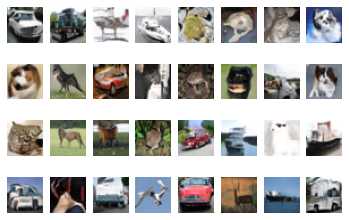

Epoch 0320/1000 : 248100 - discriminator_loss: 3.7903 generator_loss: -65.7024
Epoch 0320/1000 : 248200 - discriminator_loss: 4.0855 generator_loss: -66.4913
Epoch 0320/1000 : 248300 - discriminator_loss: 4.9135 generator_loss: -69.3111
Epoch 0320/1000 : 248400 - discriminator_loss: 3.1102 generator_loss: -71.2058
Epoch 0320/1000 : 248500 - discriminator_loss: 4.2817 generator_loss: -74.9832
Epoch 0320/1000 : 248600 - discriminator_loss: 3.4220 generator_loss: -74.8599
Epoch 0321/1000 : 248700 - discriminator_loss: 5.5789 generator_loss: -75.1449
Epoch 0321/1000 : 248800 - discriminator_loss: 6.0690 generator_loss: -79.7731
Epoch 0321/1000 : 248900 - discriminator_loss: 4.8298 generator_loss: -74.8008
Epoch 0321/1000 : 249000 - discriminator_loss: 8.2458 generator_loss: -80.4114


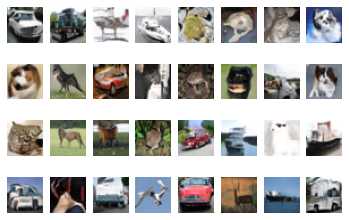

Epoch 0321/1000 : 249100 - discriminator_loss: 6.1913 generator_loss: -80.7852
Epoch 0321/1000 : 249200 - discriminator_loss: 7.3794 generator_loss: -81.8697
Epoch 0321/1000 : 249300 - discriminator_loss: 3.8903 generator_loss: -82.8987
Epoch 0321/1000 : 249400 - discriminator_loss: 7.8324 generator_loss: -83.9451
Epoch 0322/1000 : 249500 - discriminator_loss: 3.8193 generator_loss: -84.5434
Epoch 0322/1000 : 249600 - discriminator_loss: 5.5765 generator_loss: -85.2168
Epoch 0322/1000 : 249700 - discriminator_loss: 6.8230 generator_loss: -87.3260
Epoch 0322/1000 : 249800 - discriminator_loss: 6.2871 generator_loss: -87.6926
Epoch 0322/1000 : 249900 - discriminator_loss: 7.2144 generator_loss: -89.1300
Epoch 0322/1000 : 250000 - discriminator_loss: 4.4149 generator_loss: -88.3232


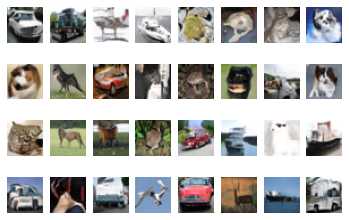

Epoch 0322/1000 : 250100 - discriminator_loss: 7.3272 generator_loss: -90.4511
Epoch 0322/1000 : 250200 - discriminator_loss: 6.3242 generator_loss: -89.0576
Epoch 0323/1000 : 250300 - discriminator_loss: 5.9709 generator_loss: -89.9210
Epoch 0323/1000 : 250400 - discriminator_loss: 5.1749 generator_loss: -93.1564
Epoch 0323/1000 : 250500 - discriminator_loss: 7.4832 generator_loss: -94.5852
Epoch 0323/1000 : 250600 - discriminator_loss: 6.5781 generator_loss: -93.2795
Epoch 0323/1000 : 250700 - discriminator_loss: 7.4592 generator_loss: -92.8915
Epoch 0323/1000 : 250800 - discriminator_loss: 7.6281 generator_loss: -94.4493
Epoch 0323/1000 : 250900 - discriminator_loss: 9.2188 generator_loss: -95.9922
Epoch 0323/1000 : 251000 - discriminator_loss: 9.6049 generator_loss: -96.3966


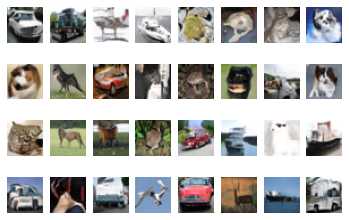

Epoch 0324/1000 : 251100 - discriminator_loss: 8.4180 generator_loss: -96.7035
Epoch 0324/1000 : 251200 - discriminator_loss: 7.3292 generator_loss: -96.0320
Epoch 0324/1000 : 251300 - discriminator_loss: 10.1450 generator_loss: -98.4897
Epoch 0324/1000 : 251400 - discriminator_loss: 7.3035 generator_loss: -98.6450
Epoch 0324/1000 : 251500 - discriminator_loss: 8.1138 generator_loss: -98.9137
Epoch 0324/1000 : 251600 - discriminator_loss: 8.5398 generator_loss: -100.8794
Epoch 0324/1000 : 251700 - discriminator_loss: 8.2468 generator_loss: -101.4676
Epoch 0324/1000 : 251800 - discriminator_loss: 5.0967 generator_loss: -103.1071
Epoch 0325/1000 : 251900 - discriminator_loss: 9.5013 generator_loss: -103.1683
Epoch 0325/1000 : 252000 - discriminator_loss: 8.6377 generator_loss: -102.1402


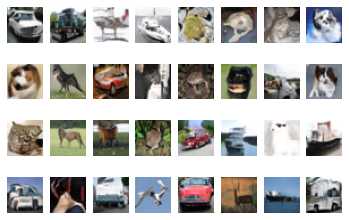

Epoch 0325/1000 : 252100 - discriminator_loss: 12.0745 generator_loss: -103.9166
Epoch 0325/1000 : 252200 - discriminator_loss: 8.7443 generator_loss: -102.6127
Epoch 0325/1000 : 252300 - discriminator_loss: 12.0320 generator_loss: -104.1945
Epoch 0325/1000 : 252400 - discriminator_loss: 8.9819 generator_loss: -104.1705
Epoch 0325/1000 : 252500 - discriminator_loss: 9.9376 generator_loss: -104.5009
Epoch 0326/1000 : 252600 - discriminator_loss: 8.9226 generator_loss: -105.0500
Epoch 0326/1000 : 252700 - discriminator_loss: 9.5540 generator_loss: -105.6388
Epoch 0326/1000 : 252800 - discriminator_loss: 10.9217 generator_loss: -104.9183
Epoch 0326/1000 : 252900 - discriminator_loss: 8.6058 generator_loss: -105.3792
Epoch 0326/1000 : 253000 - discriminator_loss: 9.4376 generator_loss: -107.7724


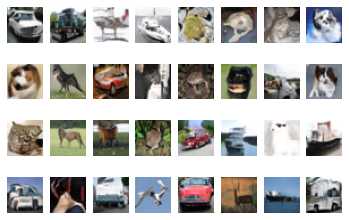

In [ ]:
trainer.run(train_loader, max_epochs=1000)

# Evaluation

Let us first load up the latest iteration of the models. We only need the generator.

In [ ]:
pretrained = torch.load(f'{save_dir}/checkpoints/checkpoint_253000.pt')

In [ ]:
generator.load_state_dict(pretrained['generator'])

<All keys matched successfully>

The dictionaries are storing duplicates of the weight tensors. We can get rid of them to release the memory.

In [ ]:
del pretrained

Lets put the generator into evaluation mode.

In [ ]:
generator.eval()

Generator(
  (embedding_projection): EmbeddingProjection(
    (fc): Linear(in_features=256, out_features=65536, bias=True)
  )
  (positional_embeddings): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 1x64x1024 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 1x256x256 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 1x1024x64 (GPU 0)]
  )
  (upsampling): Resampling(
    (resampling): PixelShuffle(upscale_factor=2)
  )
  (stages): ModuleList(
    (0): StageBlock(
      (0): EncoderBlock(
        (attention): GridAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (feedforward): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(a

We can visually inspect the results:

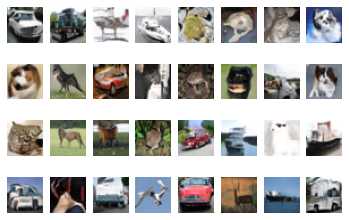

In [ ]:
visualize_progress(None)

But more importantly, we need to calculate the IS and the FID of the model. The official implementation manually implements these metrics and surprisingly, uses TensorFlow for the process. We are going to use the metrics available in `torch-ignite` instead. However, we need to make a crucial change in `FID`.

In both implementations, `InceptionV3` is used for feature extraction. However, while `torch-ignite` implementation use the features extracted at the final layer (the 1000-D logit vector), the official implementation uses the features returned by the global pooling layer just before the FC output layer ([code](https://github.com/VITA-Group/TransGAN/blob/51b00d9ebdbcbeb42f4be2181fed394219f10e73/utils/fid_score.py#L77)). We need to alter our metric accordingly.

In [ ]:
feature_extractor = inception_v3(pretrained=True)
feature_extractor.fc = nn.Identity()
feature_extractor.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
fid_metric = FID(num_features=2048, feature_extractor=feature_extractor, device=device)

In [ ]:
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

While `FID` requires both a batch of real images, and a batch of fake ones, `InceptionScore` only needs the generated images. Therefore, we need tp use argument `output_transform` to only take the generated batch out of the tuple.

We define the function for the evaluation engine, namely, `evaluation_step`. Our dataset provides 32 x 32 x 3 images but Inceptionv3 requires images of [minimum size 299 x 299 x 3](https://pytorch.org/hub/pytorch_vision_inception_v3/), so the images from the dataset and the images generated by the generator model must be upscaled.

Although PyTorch has a native interpolate function, PIL interpolation is used instead because of poor anit-aliasing in `torch` which can lead to poor scaling of images. These inconsistencies among implementations can have a drastic effect on the evaluations metrics and their final results. [Parmar et al. (2021)](https://arxiv.org/abs/2104.11222) explains in much greater detail about the differences and inconsistencies in the interpolation functions of various libraries.

In [ ]:
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [ ]:
def evaluation_step(engine, batch):
    real_batch, labels = batch
    batch_size = len(real_batch)
    with torch.no_grad():
        noise = torch.randn(batch_size, LATENT_DIMS, device=device)
        fake_batch = generator(noise)
        fake = interpolate(fake_batch)
        real = interpolate(real_batch)
        return fake, real

In [ ]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

And the final results are:

In [ ]:
results = evaluator.run(test_loader, max_epochs=1)

In [ ]:
results.metrics 

{'fid': 4.11961057649421, 'is': 2.021161436877151}

The original paper reports that the final model acheieved an FID of `9.26` (lower is better) and an IS of `9.02` (higher is better). Note that IS measures the diversity of quality of the images, based on weights its learned from ImageNet, while FID compares the diversity and quality of the images coming from the training set and the generator.